In [42]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [43]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

In [44]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSamples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [45]:
#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset


In [46]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [47]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)
    
    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

In [48]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
seqLength = 8
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData("data/walmart-sales-dataset-of-45stores.csv",
    testPercent, seqLength, batchSize) 

# Basic RNN

This was the first tested approach (all discussion regarding the results takes into account 68.000 as a good result, as stipulated by the problem description), and its results aren't good at all. The dimensionalities tested were 16, 32 and 48, and neither of them showed good results.

In [98]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.SimpleRNN(48)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_basic_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 48)                2640      
                                                                 
 dense_26 (Dense)            (None, 1)                 49        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

#model = keras.models.load_model("walmart_basic_rnn.keras") 
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
4365/4365 [==============================] - 25s 5ms/step - loss: 0.1083 - mae: 0.2127 - val_loss: 0.3760 - val_mae: 0.5167
Epoch 2/50
4365/4365 [==============================] - 22s 5ms/step - loss: 0.0799 - mae: 0.1803 - val_loss: 0.2662 - val_mae: 0.4255
Epoch 3/50
4365/4365 [==============================] - 24s 6ms/step - loss: 0.0626 - mae: 0.1642 - val_loss: 0.2365 - val_mae: 0.4062
Epoch 4/50
4365/4365 [==============================] - 27s 6ms/step - loss: 0.0591 - mae: 0.1585 - val_loss: 0.1996 - val_mae: 0.3761
Epoch 5/50
4365/4365 [==============================] - 27s 6ms/step - loss: 0.0499 - mae: 0.1499 - val_loss: 0.3679 - val_mae: 0.5340
Epoch 6/50
4365/4365 [==============================] - 22s 5ms/step - loss: 0.0506 - mae: 0.1493 - val_loss: 0.2319 - val_mae: 0.4166
Epoch 7/50
4365/4365 [==============================] - 26s 6ms/step - loss: 0.0450 - mae: 0.1432 - val_loss: 0.1784 - val_mae: 0.3692
Epoch 8/50
4365/4365 [==============================] -

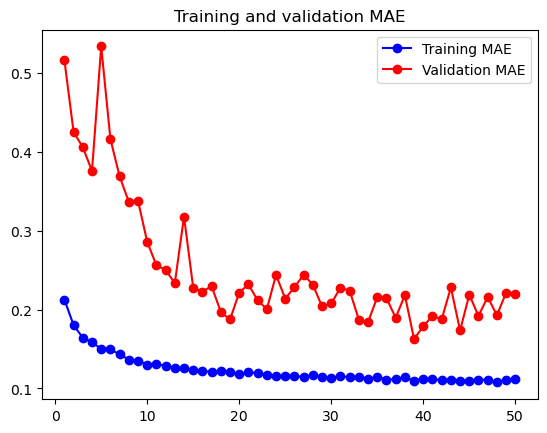

Lowest validation MAE:  92961.25046889883


In [100]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Basic GRU

This is the best approach by far, just using a simple GRU without any further addition or modification, reaching the desired MAE. This might be the case due to the "simplicity" of the problem, where the sales patterns tend to repeat themselves (christmas sale, black friday sale, and so on) without many deviations, thus a very complex model wouldn't be efficient to solve it.

Dimensionalities of 16, 32 and 48 have been tested, being 48 the one that provided the best MAE.

In [69]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.GRU(48)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_basic_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 gru_7 (GRU)                 (None, 48)                8064      
                                                                 
 dense_16 (Dense)            (None, 1)                 49        
                                                                 
Total params: 8,113
Trainable params: 8,113
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

#model = keras.models.load_model("walmart_basic_rnn.keras") 
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
4365/4365 [==============================] - 60s 13ms/step - loss: 0.1055 - mae: 0.1949 - val_loss: 0.1146 - val_mae: 0.2669
Epoch 2/50
4365/4365 [==============================] - 30s 7ms/step - loss: 0.0456 - mae: 0.1405 - val_loss: 0.0681 - val_mae: 0.2010
Epoch 3/50
4365/4365 [==============================] - 33s 7ms/step - loss: 0.0362 - mae: 0.1259 - val_loss: 0.0687 - val_mae: 0.1888
Epoch 4/50
4365/4365 [==============================] - 36s 8ms/step - loss: 0.0333 - mae: 0.1197 - val_loss: 0.0707 - val_mae: 0.1978
Epoch 5/50
4365/4365 [==============================] - 40s 9ms/step - loss: 0.0309 - mae: 0.1158 - val_loss: 0.0635 - val_mae: 0.1803
Epoch 6/50
4365/4365 [==============================] - 40s 9ms/step - loss: 0.0307 - mae: 0.1143 - val_loss: 0.0608 - val_mae: 0.1762
Epoch 7/50
4365/4365 [==============================] - 41s 9ms/step - loss: 0.0293 - mae: 0.1111 - val_loss: 0.0639 - val_mae: 0.1805
Epoch 8/50
4365/4365 [==============================] 

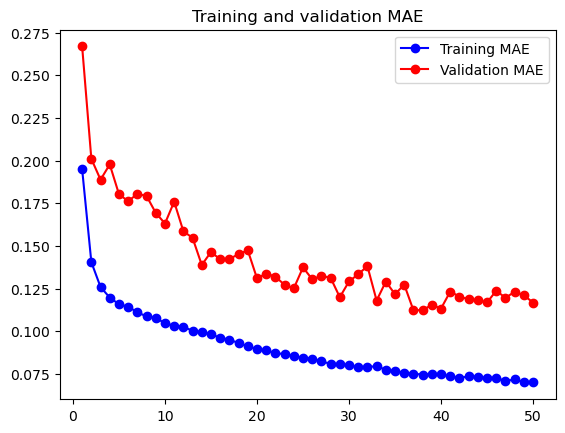

Lowest validation MAE:  64203.30646154187


In [71]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Recurrent Dropout

Different dropout values have been tested, ranging from 0.1 to 0.5, but in the end this didn't help improve the MAE at all, only provided worse results. The basic GRU approach didn't show overfitting, thus makes sense that this problem does not require to apply dropout to the networks. 

In [72]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.LSTM(32, recurrent_dropout=0.10)(inputs)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_recurrent_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                4992      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/50
4365/4365 [==============================] - 45s 10ms/step - loss: 0.1451 - mae: 0.2403 - val_loss: 0.2038 - val_mae: 0.3724
Epoch 2/50
4365/4365 [==============================] - 47s 11ms/step - loss: 0.1023 - mae: 0.2064 - val_loss: 0.1995 - val_mae: 0.3562
Epoch 3/50
4365/4365 [==============================] - 43s 10ms/step - loss: 0.0913 - mae: 0.1940 - val_loss: 0.1966 - val_mae: 0.3491
Epoch 4/50
4365/4365 [==============================] - 45s 10ms/step - loss: 0.0851 - mae: 0.1868 - val_loss: 0.1743 - val_mae: 0.3187
Epoch 5/50
4365/4365 [==============================] - 46s 11ms/step - loss: 0.0791 - mae: 0.1827 - val_loss: 0.1370 - val_mae: 0.2862
Epoch 6/50
4365/4365 [==============================] - 52s 12ms/step - loss: 0.0751 - mae: 0.1793 - val_loss: 0.1448 - val_mae: 0.2950
Epoch 7/50
4365/4365 [==============================] - 52s 12ms/step - loss: 0.0648 - mae: 0.1706 - val_loss: 0.1216 - val_mae: 0.2540
Epoch 8/50
4365/4365 [==========================

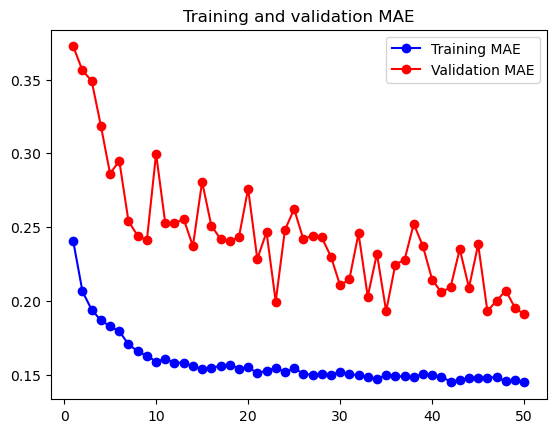

Lowest validation MAE:  109091.44980069168


In [74]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Stacking Recurrent Layers

This approach has the potential to provide even better results than the basic GRU, but we still would have to increase the number of training epochs, thus making it extremely inefficient compared to the other approach.

In [95]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.GRU(48, return_sequences=True)(inputs)
x = layers.GRU(48)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_stacked_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 gru_12 (GRU)                (None, 8, 48)             8064      
                                                                 
 gru_13 (GRU)                (None, 48)                14112     
                                                                 
 dense_25 (Dense)            (None, 1)                 49        
                                                                 
Total params: 22,225
Trainable params: 22,225
Non-trainable params: 0
_________________________________________________________________


In [96]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/50
4365/4365 [==============================] - 75s 16ms/step - loss: 0.1001 - mae: 0.1937 - val_loss: 0.2362 - val_mae: 0.3716
Epoch 2/50
4365/4365 [==============================] - 71s 16ms/step - loss: 0.0464 - mae: 0.1393 - val_loss: 0.1412 - val_mae: 0.2678
Epoch 3/50
4365/4365 [==============================] - 69s 16ms/step - loss: 0.0380 - mae: 0.1282 - val_loss: 0.1234 - val_mae: 0.2495
Epoch 4/50
4365/4365 [==============================] - 74s 17ms/step - loss: 0.0347 - mae: 0.1220 - val_loss: 0.1238 - val_mae: 0.2480
Epoch 5/50
4365/4365 [==============================] - 71s 16ms/step - loss: 0.0326 - mae: 0.1179 - val_loss: 0.0987 - val_mae: 0.2224
Epoch 6/50
4365/4365 [==============================] - 76s 17ms/step - loss: 0.0311 - mae: 0.1143 - val_loss: 0.0979 - val_mae: 0.2218
Epoch 7/50
4365/4365 [==============================] - 78s 18ms/step - loss: 0.0296 - mae: 0.1119 - val_loss: 0.1240 - val_mae: 0.2569
Epoch 8/50
4365/4365 [==========================

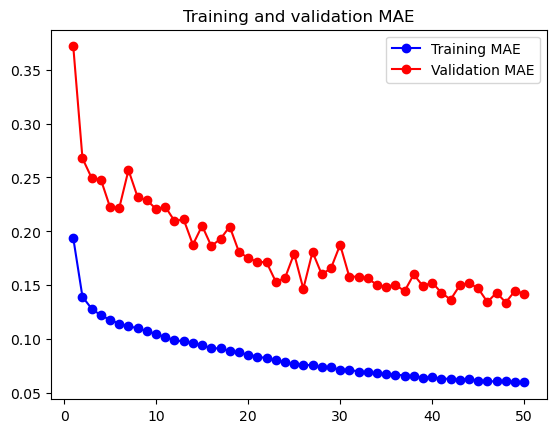

Lowest validation MAE:  76601.0271579655


In [97]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Bidirectional RNNs

In [101]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.Bidirectional(layers.LSTM(32))(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/walmart_bidirectional_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               9984      
 nal)                                                            
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________


In [102]:
history = model.fit(trainData,
                    epochs=50,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/50
4365/4365 [==============================] - 33s 7ms/step - loss: 0.1035 - mae: 0.1915 - val_loss: 0.1573 - val_mae: 0.3226
Epoch 2/50
4365/4365 [==============================] - 35s 8ms/step - loss: 0.0744 - mae: 0.1625 - val_loss: 0.0914 - val_mae: 0.2427
Epoch 3/50
4365/4365 [==============================] - 39s 9ms/step - loss: 0.0590 - mae: 0.1470 - val_loss: 0.0683 - val_mae: 0.2074
Epoch 4/50
4365/4365 [==============================] - 45s 10ms/step - loss: 0.0458 - mae: 0.1358 - val_loss: 0.0661 - val_mae: 0.2013
Epoch 5/50
4365/4365 [==============================] - 51s 12ms/step - loss: 0.0362 - mae: 0.1257 - val_loss: 0.0591 - val_mae: 0.1842
Epoch 6/50
4365/4365 [==============================] - 53s 12ms/step - loss: 0.0331 - mae: 0.1202 - val_loss: 0.0665 - val_mae: 0.1986
Epoch 7/50
4365/4365 [==============================] - 59s 13ms/step - loss: 0.0320 - mae: 0.1172 - val_loss: 0.0657 - val_mae: 0.1972
Epoch 8/50
4365/4365 [=============================

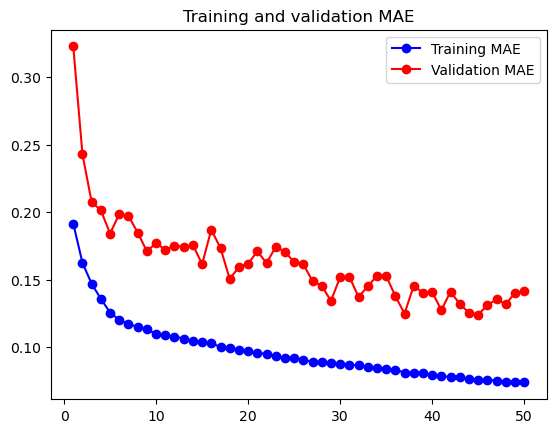

Lowest validation MAE:  70992.94216560402


In [103]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)